In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from scipy.optimize import curve_fit

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Study Summary
A study seeks to quantify the effectivity of a drug in a clinical population with systemic hypertension (SH). The team enrolled 250 patients with diagnosis of SH and no other known comorbidities. For each individual, the systolic blood pressure was measured after a minimum of 12 hours of fasting. Then, a random safe dose of the tested drug within acceptable thresholds was administered daily during a period of 30 days, after which the systolic blood pressure was measured again.

The principal investigator of this project is interested in quantifying if the systolic blood pressure can be predicted after 30 days of treatment based on the measured values before the treatment, the administered drug dose and basic patient information such as age and/or sex.

In [2]:
# Import data
WORK_DIR = os.getcwd()
filename = 'BloodPressureData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),"Sex (0:female, 1:male)",Initial systolic pressure (mm Hg),Drug dose (mg),Systolic pressure after treatment (mm Hg)
0,86,0,171.221889,7.144833,153.874218
1,79,0,166.426064,7.984246,143.468111
2,90,1,163.676760,7.271092,148.559803
3,85,1,146.621486,7.770628,124.180775
4,81,1,142.752645,7.233099,123.560301


# Note

Usually we would perform a more extensive EDA/data cleaning section checking variable/outcome distributions, evidence of multicollinearity, missing data, outliers, etc. The focus of this notebook is on model fitting/evaluation. Later modules will incorporate the EDA/data cleaning techniques.

# Linear Regression Model
Build and evaluate a regression model that can predict the systolic blood pressure after 30 days of treatment.

In [3]:
# Choose features and target and represent as numpy matrices
X = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].to_numpy()
y = data.loc[:, 'Systolic pressure after treatment (mm Hg)'].to_numpy()

In [4]:
# State variables in terms of x1, x2, x3, x4 - want to pull directly from data set
model_varnames = [f'x{i+1}' for i in range(0, len(data.columns)-1)]
varnames = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].columns
varname_dict = dict(zip(model_varnames, varnames))
for key, value in varname_dict.items():
    print(f'{key}: {value}')

x1: Age (years)
x2: Sex (0:female, 1:male)
x3: Initial systolic pressure (mm Hg)
x4: Drug dose (mg)


## Model Equation

$$\hat{y} = \theta_0 + \theta_{1}x_1 + \theta_{2}x_2 + \theta_{3}x_3 + \theta_{4}x_4$$

$$\hat{y} = -7.40 + 0.06x_1 + 2.79x_2 + 1.02x_3 + -3.07x_4$$

Where...
- $\hat{y}$ is the target outcome, systolic pressure after treatment (mm Hg)
- $x_1$, $x_2$, $x_3$, and $x_4$ are the features
- $\theta_1$, $\theta_2$, $\theta_3$, and $\theta_4$ are the coefficients associated with each feature
- $\theta_0$ is the intercept, which is uninterpretable in this case

## Model Summary

In [5]:
# Fit model and display results
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1489.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):          1.48e-170
Time:                        01:05:17   Log-Likelihood:                -651.85
No. Observations:                 250   AIC:                             1314.
Df Residuals:                     245   BIC:                             1331.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4072      3.216     -2.303      0.0

In [6]:
# Predict systolic blood pressure after treatment using linear regression model
predictions = model.predict(X)
data['Prediction (mm Hg)'] = predictions
data['Residuals'] = model.resid

## Performance Evaluation
For evaluation here we will use all training set data

In [7]:
# Print performance metrics
print(f'MAE: {round(sum(abs(model.resid)) / model.nobs, 2)}')
print(f'MSE: {round(sum(model.resid * model.resid) / model.nobs, 2)}')
print(f'R-squared: {round(model.rsquared, 2)}')
print(f'Adjusted R-squared: {round(model.rsquared_adj, 2)}')

MAE: 2.55
MSE: 10.77
R-squared: 0.96
Adjusted R-squared: 0.96


- **Mean absolute error** does not penalize large prediction errors. An MAE of 2.55 is achieved by this model, compared to a perfect score of 0.
- **Mean squared error (MSE)** penalizes large prediction errors. An MSE of 10.77 is achieved by this model, compared to a perfect score of 0. The discrepancy that exists between MAE and MSE for this model might suggest the presence of some outlier residuals - although the discrepancy isn't large.
- **R-squared & Adjusted R-squared** are each 0.960. Considering perfect scores of 1 for these metrics, $R^2$ of 0.96 suggests good model performance.
  
*The next section asseses the relationship between residuals and features to check if model assumptions are met*

# Model Diagnostics & Discussion

In [85]:
# Function to plot scatterplot; boolean flag used to display variable distributions (or not)
def res_scatter(df, x_col, y_col):
    plt.figure()
    g = sns.JointGrid(data=data, x=x_col, y=y_col)
    g.plot_joint(sns.residplot, lowess=True)
    g.plot_marginals(sns.histplot)
    plt.show()


## Residuals vs Predicted Outcome
The residual distribution is not evenly/normally distributed around zero. The skew exists due to outlier residual values above the y axis - these are observations in which the model underpredicted the true value.

<Figure size 432x288 with 0 Axes>

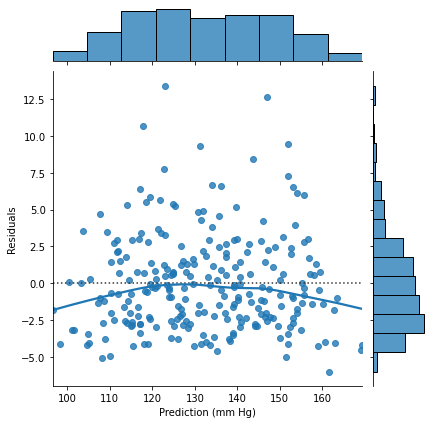

In [86]:
res_scatter(df=data, x_col='Prediction (mm Hg)', y_col='Residuals')

## Residuals vs Features

### Age

Age is associated with a $\theta$ value of 0.05 and a $p$-value of 0.018, suggesting a significant association between age and the outcome predicted. Theoretically, a $\theta$ value of 0.05 indicates that for every 1 year increase in age, systolic blood pressure increases by 0.05 units (mm Hg). However, the residual plot below shows a clear parabolic relationship between prediction error and age. This pattern tells us that a non-linear relationship likely exists between age and the outcome. We ought to update the linear regression model to account for this.

<Figure size 432x288 with 0 Axes>

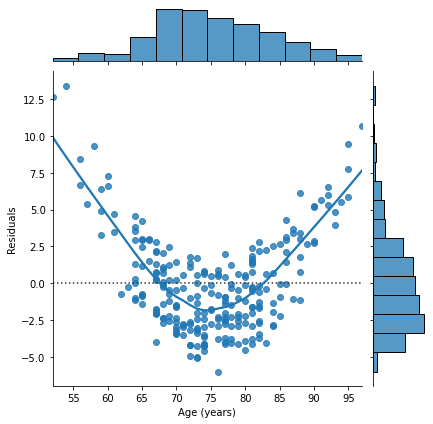

In [87]:
res_scatter(df=data, x_col='Age (years)', y_col='Residuals')

### Sex
Age is associated with a $\theta$ value of 2.78 and a $p$-value of <0.001, suggesting a significant association between sex and the outcome predicted. A $\theta$ value of 2.78 indicates that males, on average, are associated with a 2.78 unit increase in systolic blood pressure when compared to females.

<Figure size 432x288 with 0 Axes>

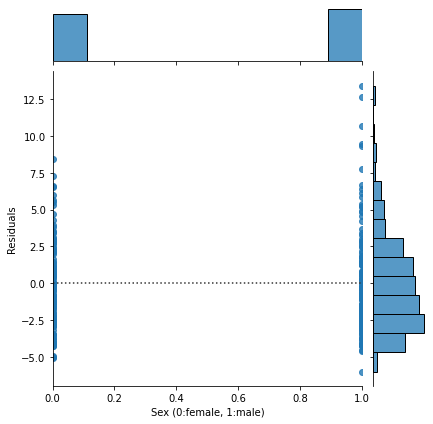

In [89]:
res_scatter(df=data, x_col='Sex (0:female, 1:male)', y_col='Residuals')

### Initial Systolic Blood Pressure
Age is associated with a $\theta$ value of 1.02 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of 1.02 indicates that for every 1 unit increase in initial systolic blood pressure (mm Hg), systolic blood pressure increases by 1.02 units (mm Hg). The residual plot below indicates that a linear relationship is indeed observed between the variable and the outcome.

<Figure size 432x288 with 0 Axes>

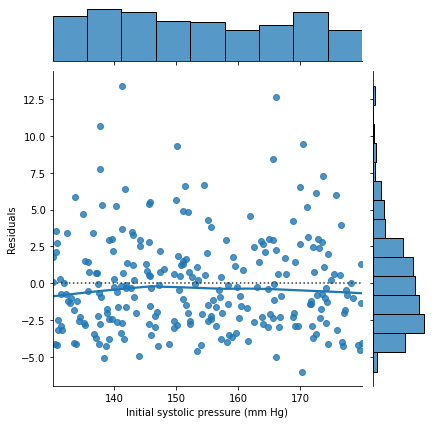

In [91]:
res_scatter(df=data, x_col='Initial systolic pressure (mm Hg)', y_col='Residuals')

### Drug Dose
Drug dose is associated with a $\theta$ value of -3.07 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of -3.07 indicates that for every 1 unit increase in drug dose (mg), systolic blood pressure decreases by 3.07 units (mm Hg). However, the residual plot below indicates that a non-linear relationship might exist between the variable and the outcome. This isn't as obvious as the pattern observed for age, but some optimization can likely be done.

<Figure size 432x288 with 0 Axes>

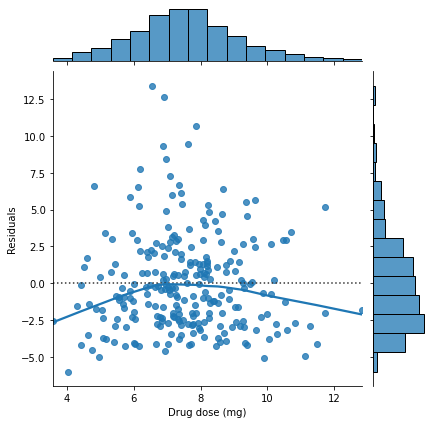

In [92]:
res_scatter(df=data, x_col='Drug dose (mg)', y_col='Residuals')

# Non-Linear Regression Model

$$\hat{y} = \theta_0 + \theta_{1}x_1^2 + \theta_{2}x_2 + \theta_{3}x_3 + \theta_{4}x_4$$

In [96]:
def nonlin_func(X, theta_0, theta_1, theta_2, theta_3, theta_4):
    '''
    Non-linear function to account for non-linear relationships in linear regression model;
    Use with scipy.optimize.curve_fit
    '''
    x1, x2, x3, x4 = X[:, 1], X[:, 2], X[:, 3], X[:, 4]
    return (theta_0) + (theta_1 * x1**2) + (theta_2 * x1) + (theta_3 * x3) + (theta_4 * x4)

# Fit non-linear regression model and extract
popt, pcov = curve_fit(nonlin_func, X, y)
y_pred = nonlin_func(X, *popt)
nonlin_residuals = y - y_pred
data['Nonlinear Prediction (mm Hg)'] = y_pred
data['Nonlinear Residuals'] = nonlin_residuals

## Residuals vs Predicted Outcome
The residual distribution is now evenly/approximately normally distributed around zero, which is good to see. Residual range is now roughly (-5, 5) versus (-5, 13), indicating that the model is no longer heavily underpredicting true values for some observations.

<Figure size 432x288 with 0 Axes>

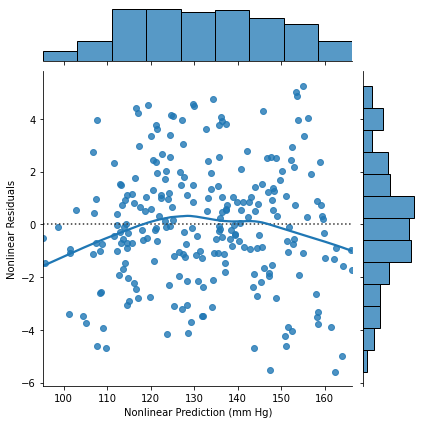

In [97]:
res_scatter(df=data, x_col='Nonlinear Prediction (mm Hg)', y_col='Nonlinear Residuals')

## Residuals vs Features
No pattern is observed now for age vs residuals, which suggests a parabolic relationship might, in fact, exist between age and the outcome. We may have introduced a new problem, however. It appears that the model is now underpredicting values for males and overpredicting values for females. We should adjust for this in a future model..

<Figure size 432x288 with 0 Axes>

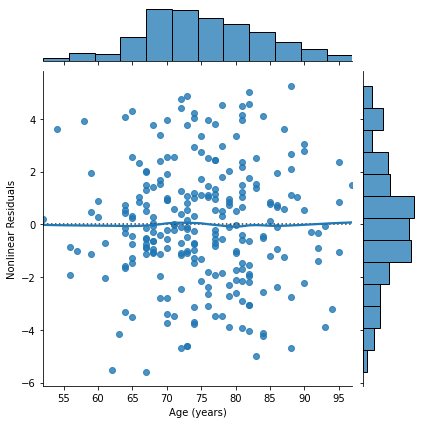

<Figure size 432x288 with 0 Axes>

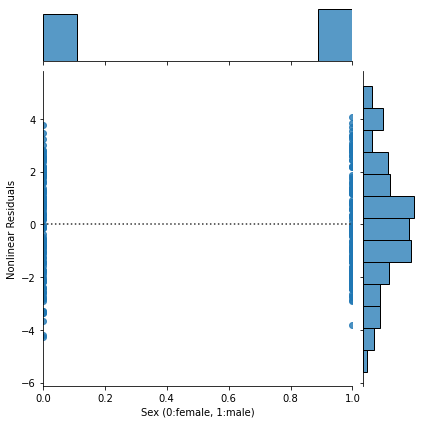

<Figure size 432x288 with 0 Axes>

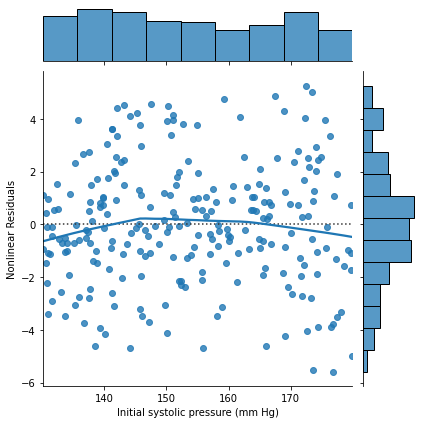

<Figure size 432x288 with 0 Axes>

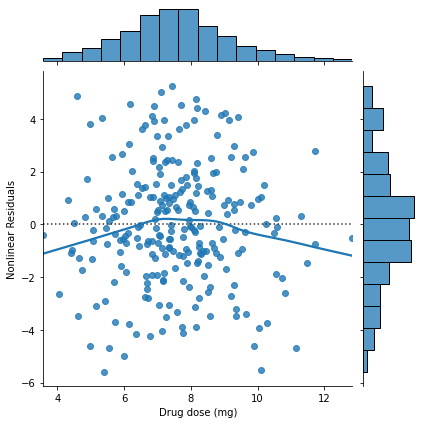

In [98]:
for feature in varnames:
    res_scatter(df=data, x_col=feature, y_col='Nonlinear Residuals')